# Map 2D data

This notebook will have the algorithm for how to map 2D data using the (george package)[https://george.readthedocs.io/en/latest/]. 

>An example of doing this is present in https://gist.github.com/shoyer/80aa06f5ad44aacd9187 (using an older version of george).

The main steps are: 

First things first  
https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.



 *Using GP regression to grid ungridded data*

In [1]:
# Load appropriate modules
import george
from george import kernels
from george.kernels import Matern32Kernel

import numpy as np
import matplotlib.pyplot as plt
from itertools import product


KeyboardInterrupt: 

In [2]:
# Relevant definitions 

In [3]:
# Optimisation routines

# From first example

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [4]:
# on hyperparameterisation

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    print(p)
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True, )
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)


In [265]:
def fake_2d_data(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0] + x[:, 1]) + yerr * np.random.randn(len(x))
    return x, y





thinking about the time axis 

K&T 2018 - Sum of three Matern / Exp functions describing the covariance of the variable 
1. with reference to lat
2. with reference to lon
3. with reference to time




## following shoyer 

1 Generate 2D data (e.g. could be a 2D function like : sin (x+y) + error ),with some prescribed parameters.
  -- Alternatively, we could just use a test data set that I have for this step that has data that 
  -- is a function of (lat, lon, time), like the Argo data will be.

https://gist.github.com/shoyer/80aa06f5ad44aacd9187

## Using Matern32

Adopted by Park et al 2020  
With the advantage of the results being differentiable


In [348]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T



In [349]:
x.shape

(1000, 2)

In [353]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(metric=0.5, ndim=2)   #Metric is the length scale (defined in sci-kit learn) of the kernel. 
                                                    #If a float, an isotropic kernel is used.
                                                    #If an array, an anisotropic kernel is used where
                                                    #each dimension of l defines the length-scale of the
                                                    #respective feature dimension. 
# Instead of constant kernal add variance of GP?

kernel = np.var(y) * Matern32Kernel(metric=0.5, ndim=2)
                
# This test data is isotropic, but the ocean is anisotropic

#kernel = 0.5 * Matern32Kernel(metric=[[5,4],[1,5]], ndim=2)  # Example using varying length scales, this is the generarl case
#kernel = kernels.ExpSquaredKernel(metric=[13.0, 0.1],ndim=2)  # Variances in different directions (axis-aligned option)
#(tested here to see how this changes/distorts the estimated field - the optimisation function fixes this! )
# There is a third option, general case, which allows for arbitrary covariances between dimensions (e.g metric = [[12.0, 0.1],[0.1,13.0]])
# Smaller length scales result in more complex functions

print('Parameter vector',kernel.get_parameter_vector())
gpBasic = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
print(x.shape)
gpBasic.compute(x) 

print(y.shape)
print(test_pts.shape)

mu, cov = gpBasic.predict(y, test_pts) # this is where George performs maximum likelihood estimation

Parameter vector [-1.32881023 -0.69314718]
(1000, 2)
(1000,)
(2500, 2)


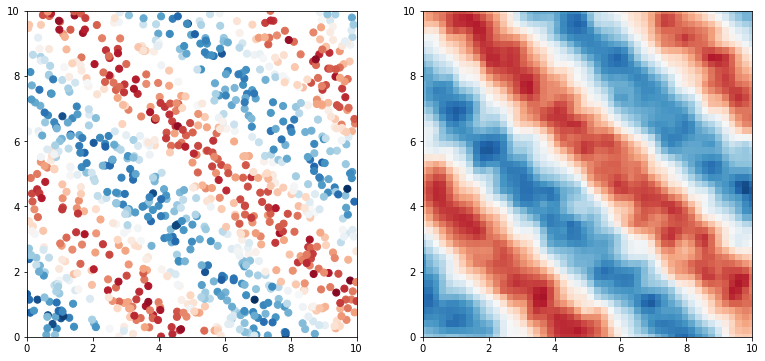

In [268]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

Optimize

In [269]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -187.45


In [330]:
x.shape

(1000, 2)

In [331]:
y.shape

(1000,)

In [332]:
p0

array([-3.32146241, -1.34056218, -0.69314718])

In [333]:
nll

<function __main__.nll(p)>

In [328]:

# You need to compute the GP once before starting the optimization.
gpBasic.compute(x)

# Print the initial ln-likelihood.
print(gpBasic.log_likelihood(y))

# Run the optimization routine.
p0 = gpBasic.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gpBasic.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-196.35489260997844
[-3.32146241 -1.34056218 -0.69314718]
[-3.50629642 -2.00603065  0.03003199]
[-3.12007245 -2.34242652  0.65119168]
[-3.27587102 -2.17905911  0.67326453]
[-3.32295044 -2.00814486  0.83076987]
[-3.3258373  -1.52461235  1.30850811]
[-3.23850552 -0.99370835  1.77828096]
[-3.23812142 -0.62551996  2.14615067]
[-3.24692497 -0.08677637  2.47850179]
[-3.2566348   0.09044517  2.64675206]
[-3.25653952  0.14766641  2.68618855]
[-3.25580432  0.17915751  2.70735227]
[-3.25573589  0.1811901   2.70883738]
[-3.25573139  0.18122701  2.70886589]
-9.079077577126782


In [78]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -8.484262064866812
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([3.05479798e-07, 4.21673256e-07, 6.93393687e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-3.1313911 ,  0.97408999,  1.00467499])

Final ln-likelihood: 8.48


In [79]:
mu, cov = gp.predict(y, test_pts)

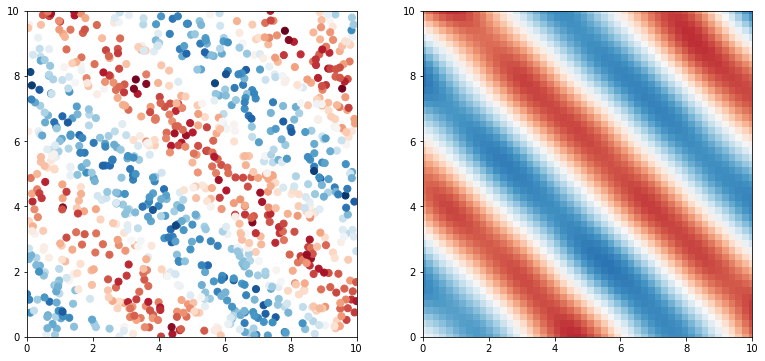

In [80]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

## Set function aligned to xaxis only

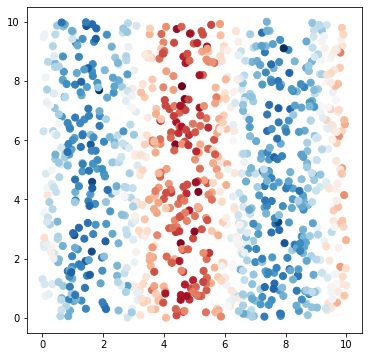

In [97]:
def fake_2d_data_vertical(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0]) + yerr * np.random.randn(len(x))
    return x, y

n_samples = 1000
x, y = fake_2d_data_vertical(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T


f, axes = plt.subplots(1, 1, figsize=(6,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)



* * *
Note on lengthscale selection / metric parameters

Isotropic = one values

Anisotropic = axis-aligned nD values
 
Units don't seem to be important.

* * *

Parameter vector [-1.44926136  0.69314718]


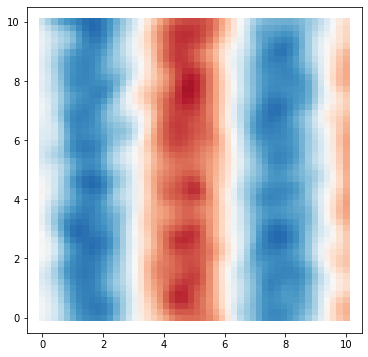

In [109]:
kernel = np.var(y) * Matern32Kernel(metric=2.0, ndim=2)  # make it isotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)



In [110]:
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))



102.71840044073616


Parameter vector [1.0593007  4.12703772]


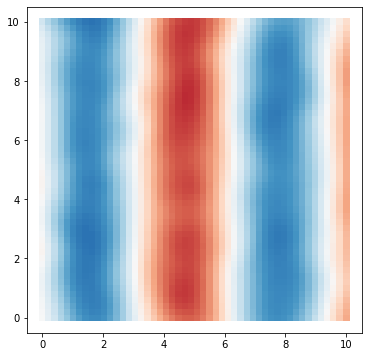

In [111]:
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


print('Parameter vector',kernel.get_parameter_vector())



Parameter vector [-1.44926136  0.69314718  2.7080502 ]
190.0113753720741
Parameter vector [-0.45815611  2.62252532 12.91212571]


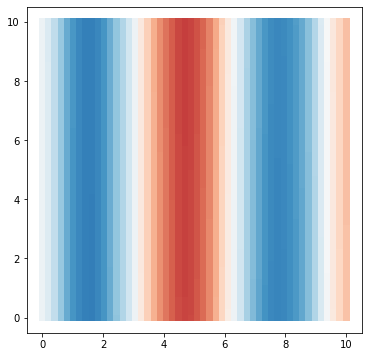

In [115]:
kernel = np.var(y) * Matern32Kernel(metric=[2.0,15], ndim=2)  # now anisotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

#, axes = plt.subplots(1, 1, figsize=(6,6))
#axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))

gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)
#axes.scatter(x[:, 0], x[:, 1], c=y, s=10, **style,edgecolors='k')



print('Parameter vector',kernel.get_parameter_vector())





Moving from isotropic to anisotropic, the parameters converge at a larger third position parameter vector

##  Exponential 
used by K&S 2018

In [385]:
test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T



CPU times: user 906 ms, sys: 17.6 ms, total: 924 ms
Wall time: 281 ms


In [386]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

from george import kernels
kernel = 0.5 * kernels.ExpSquaredKernel(0.5, ndim=2) 

gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

mu, cov = gp.predict(y, test_pts)

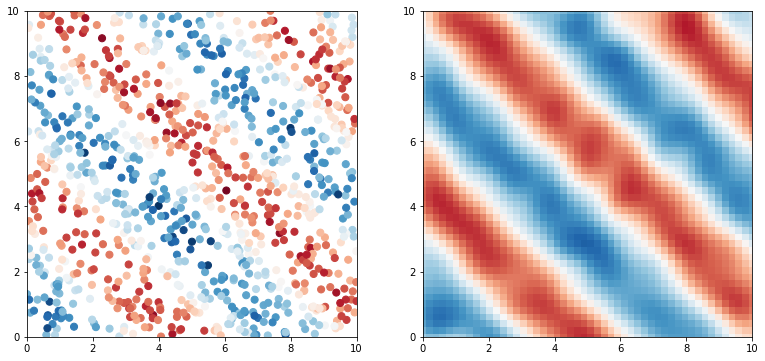

In [387]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

In [388]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -90.79


In [389]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -22.65977231802276
 hess_inv: array([[ 2.14345094e-03, -7.83241794e-05,  3.05084688e-05],
       [-7.83241794e-05,  1.78965538e-01,  5.25559211e-02],
       [ 3.05084688e-05,  5.25559211e-02,  1.91594354e-02]])
      jac: array([-1.49582204e-07, -7.91290660e-08,  5.08045872e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([-3.15705015, -0.04616422,  1.2045276 ])

Final ln-likelihood: 22.66


In [390]:
mu, cov = gp.predict(y, test_pts)

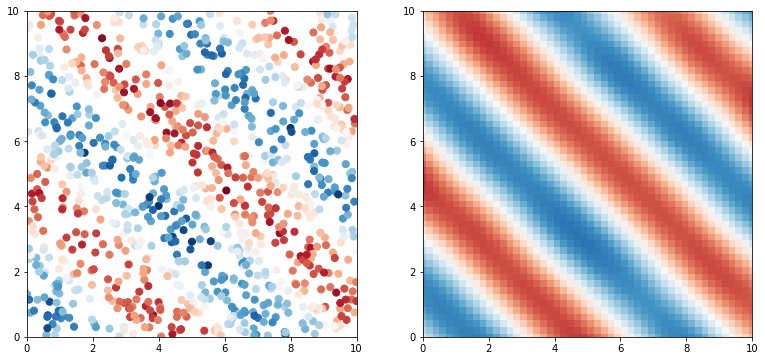

In [391]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

##  -- Decide which kernel to use for argo data



In [ ]:
#https://www.inf.ed.ac.uk/teaching/courses/mlpr/2016/notes/w7c_gaussian_process_kernels.pdf

# A Kernal is a covariance function or how related features are in space / covary with each other

# Choice linked to the distribution/ variability in region to be interpolated?

# Assume local stationarity following K&S 2018 
# Kernels that are stationary
# W&S present an anisotropic exponential space-time covariance function  - this would then allow for 3d ?

# Is it nessecary to emulate kernel from Eq 3.2 of K&S 2018 ?


## Anticipate the need to scale up

### George provides an approximate solver

In [ ]:
#Testing this out
#Compare previous to approximate solver, solutions similar, does speed things up 

In [38]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=75),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=75))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(0.5, ndim=2) 

In [39]:
gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
%time gp.compute(x)

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 39.7 ms, sys: 3.61 ms, total: 43.3 ms
Wall time: 28.9 ms
CPU times: user 3.63 s, sys: 145 ms, total: 3.77 s
Wall time: 1.24 s


In [40]:
 # quicker on the compute part 
gp_hodlr = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True,solver=george.HODLRSolver, seed=42)
%time gp_hodlr.compute(x)
print(gp_hodlr.log_likelihood(y))

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 8.71 ms, sys: 1.17 ms, total: 9.89 ms
Wall time: 9.53 ms
-501.78775542089306
CPU times: user 3.41 s, sys: 195 ms, total: 3.6 s
Wall time: 1.32 s


### Moving Window  

In [ ]:
# how did they do this? Nearest neightbours, Quadtree?  


# Try out some ARGO data

In [2]:
import xarray as xr

datafile='/Users/isabelle/Documents/coursework/oceanhackweek2020/ohw20-proj-argo-mapping/anom_data.nc'
ds = xr.open_dataset(datafile)

In [160]:
print(ds.Time.min(), ds.Time.max())
print(ds.Lon.min(), ds.Lon.max())
print(ds.Lat.min(), ds.Lat.max())

<xarray.DataArray 'Time' ()>
array('2004-05-04T22:47:06.999981824', dtype='datetime64[ns]') <xarray.DataArray 'Time' ()>
array('2017-12-31T15:18:25.000001280', dtype='datetime64[ns]')
<xarray.DataArray 'Lon' ()>
array(-144.998) <xarray.DataArray 'Lon' ()>
array(-135.00124)
<xarray.DataArray 'Lat' ()>
array(-54.998) <xarray.DataArray 'Lat' ()>
array(-45.00263)


In [6]:
# Change time to ordinal? 

import pandas as pd
pydatetime = pd.to_datetime(pd.Series(ds.Time.values.squeeze()))
ord=pydatetime.apply(lambda x: x.toordinal())

## grabbed from Druvs notebook - thanks!

In [3]:
## Argo data 
ds = xr.open_dataset('anom_data.nc')
num_samples = len(ds.r)
Xinput = np.zeros((num_samples, 3)) # 3 coordinates for lon, lat, time
Xinput[:,0] = ds.Lon.values
Xinput[:,1] = ds.Lat.values
Xinput[:,2] = ds.Time.values
Xinput[:,2] = Xinput[:,2]/1e9/24/3600 # convert to day
Yinput = ds.Data.isel(c=0).values

Xinput = xr.DataArray(Xinput, dims=["samplenum", "coordinate"], coords=[range(num_samples), ['lon','lat','time']]).rename('Input_coordinates')
Yinput = xr.DataArray(Yinput, dims=["samplenum"]).rename('Anomaly_data')

Argo_input = xr.merge([Xinput, Yinput])

Argo_input

<xarray.Dataset>
Dimensions:            (coordinate: 3, samplenum: 4089)
Coordinates:
  * samplenum          (samplenum) int64 0 1 2 3 4 ... 4084 4085 4086 4087 4088
  * coordinate         (coordinate) <U4 'lon' 'lat' 'time'
Data variables:
    Input_coordinates  (samplenum, coordinate) float64 -144.4 ... 1.741e+04
    Anomaly_data       (samplenum) float64 -0.2994 -0.2045 ... -0.3255 -0.5773

In [4]:
Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

kernel_argo = np.var(Argo_input.Anomaly_data).values*george.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)
# Let's start with a simple exponential squared kernel. 
# Also just set the prior to have isotropic dependence in space

# block arguments requires boudary parameters? 

![title](rbf.png)


In [5]:
print(kernel_argo.get_parameter_names())
print(kernel_argo.get_parameter_vector())

('k1:log_constant', 'k2:metric:log_M_0_0', 'k2:metric:log_M_1_1', 'k2:metric:log_M_2_2')
[-3.96590893  0.34240982 -0.19062036  6.80239476]


In [6]:
gp_argo = george.GP(kernel_argo)

In [7]:
test_pts_argo = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       np.linspace(-54,-46,30),
                       (2016-1970)*365)).reshape(3,-1).T
# Just chose a single test point in time for now, but it doesn't matter.

In [8]:
test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [10]:
samples_argo = gp_argo.sample(test_pts_argo, 4)

In [11]:
samples_argo = xr.DataArray(samples_argo,  dims=["func_sample_num", "test_pt_num"])

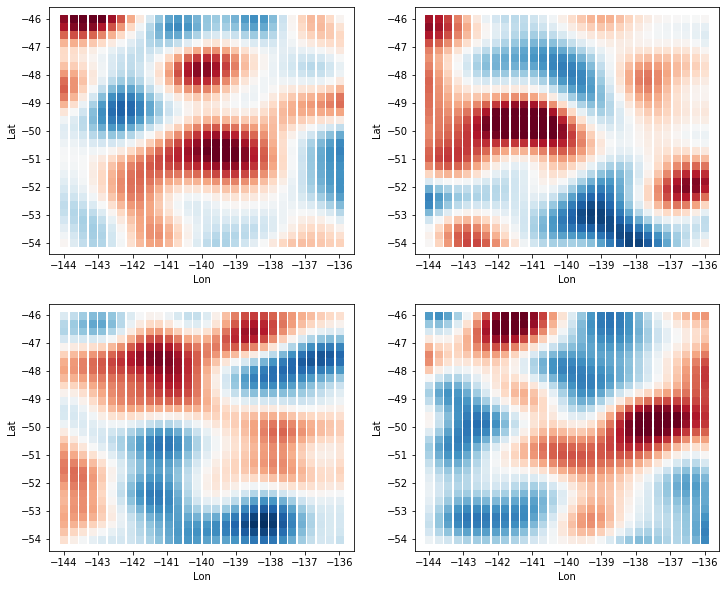

In [12]:
plt.figure(figsize=(12,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)

    plt.scatter(test_pts_argo.sel(coordinate='lon'), 
                test_pts_argo.sel(coordinate='lat'),
                c=samples_argo.sel(func_sample_num=i),
                s=50, marker='s', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    
# Since we set the length scales to be 100km, we get an eddy field
# with approximately that size in the prior set of functions.

In [21]:
# Now let us set up the GP. 

gp_argo.compute(Argo_input.Input_coordinates, 0.01)
# not sure what to set as ob error. 

In [22]:
pred_argo, pred_var_argo = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

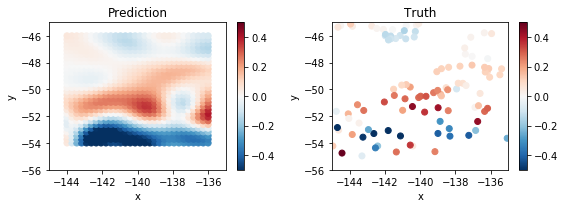

In [23]:
plt.figure(figsize=(8,3))
plt.subplot(121)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.tight_layout()



In [24]:
print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Argo_input.Anomaly_data)))

Initial ln-likelihood: 1318.47


In [25]:
def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Argo_input.Anomaly_data)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Argo_input.Anomaly_data)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [55]:
ds.Time

<xarray.DataArray 'Time' (c: 1, r: 4089)>
array([['2009-09-26T21:53:31.999998976', '2009-10-07T10:25:38.000013056',
        '2009-10-18T02:30:04.999999744', ..., '2017-08-08T14:38:29.999996416',
        '2017-08-18T15:18:24.000006656', '2017-08-28T15:50:55.000005632']],
      dtype='datetime64[ns]')
Dimensions without coordinates: c, r

In [ ]:


def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Argo_input.Anomaly_data)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Argo_input.Anomaly_data)



In [36]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 13min 41s, sys: 25.2 s, total: 14min 6s
Wall time: 4min 49s


In [37]:
print(result_argo)

      fun: -2385.7689687246466
 hess_inv: array([[ 9.28970761e-04,  4.06623983e-04,  4.61136890e-04,
         2.93410683e-04],
       [ 4.06623983e-04,  1.86827328e-03, -7.94179525e-05,
        -3.97197145e-04],
       [ 4.61136890e-04, -7.94179525e-05,  2.16175342e-03,
        -5.70652631e-04],
       [ 2.93410683e-04, -3.97197145e-04, -5.70652631e-04,
         1.59001590e-03]])
      jac: array([ 1.03978156e-05, -1.34591255e-06, -8.38855613e-07, -8.15864371e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 72
      nit: 13
     njev: 53
   status: 2
  success: False
        x: array([-3.85259318,  0.27220261, -0.92450227,  6.28170119])


In [38]:
gp_argo.set_parameter_vector(result_argo.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Argo_input.Anomaly_data)))




Final ln-likelihood: 2385.77


In [39]:
pred_MLE_argo, pred_var_MLE_argo = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo = xr.DataArray(pred_MLE_argo,  dims={"test_pt_num"})
pred_var_MLE_argo = xr.DataArray(pred_var_MLE_argo,  dims={"test_pt_num"})

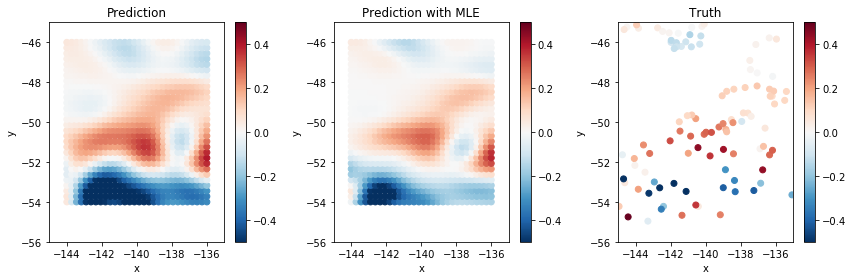

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(131)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(132)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with MLE')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.subplot(133)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(Argo_input.Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
                                drop='true')

plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([-56, -45])

plt.tight_layout()



In [41]:
# What about a time series prediction.
# Make 
test_pts_argo2 = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       -50,
                       np.linspace((2013-1970)*365, (2019-1970)*365, 120)
                                     )).reshape(3,-1).T



In [42]:
test_pts_argo2 = xr.DataArray(test_pts_argo2,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo2.shape[0]), ['lon','lat','time']] ) 

In [43]:
pred_MLE_argo2, pred_var_MLE_argo2 = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo2, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo2 = xr.DataArray(pred_MLE_argo2,  dims={"test_pt_num"})
pred_var_MLE_argo2 = xr.DataArray(pred_var_MLE_argo2,  dims={"test_pt_num"})

(2013, 2019)

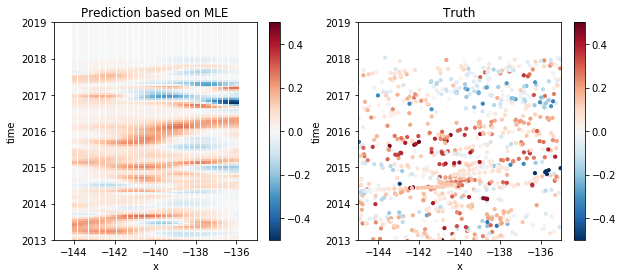

In [44]:
plt.figure(figsize=(10,4))
plt.subplot(121)

plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
plt.title('Prediction based on MLE')

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')
plt.scatter(x_sel.sel(coordinate='lon'), 
            x_sel.sel(coordinate='time')/365 + 1970, 
            c=y_sel, vmin=-.5, vmax=.5, s=10, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
# A bit hard to see, but some sign of eastward propogation is visible.
# Also since the data ends in 2018, the prediction after that is just 0.

Text(0.5, 1.0, 'Prediction based on MLE')

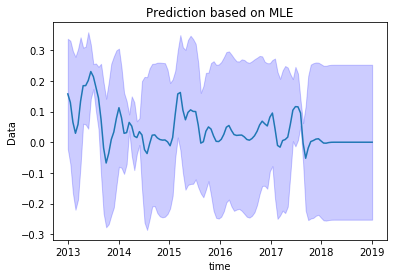

In [45]:
x_sel = test_pts_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_sel = pred_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_var = pred_var_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')

plt.fill_between(x_sel.sel(coordinate='time')/365 + 1970, 
                 y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="b", alpha=0.2)
plt.plot(x_sel.sel(coordinate='time')/365 + 1970, y_sel)
#plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
#            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
#            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.ylabel('Data')
plt.xlabel('time')

plt.title('Prediction based on MLE')

# The prediction of the time series is relatively poor,
# but considering the limited amount of data it is probably not bad.


In [46]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 2.12246257e-02 1.31285297e+00
 3.96728833e-01 5.34697515e+02]


In [47]:
print('Lx(km)='+str((np.exp(gp_argo.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo.parameter_vector[5]))**0.5))

# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Lx(km)=96.55053783998343
Ly(km)=69.28505521494583
Timescale(km)=23.123527303648945


In [16]:
results = np.ndarray(len(years))



## Split by year



Having issues with inf/nans. Dimension mismatch meant I need to recompute the gp with each iteration to run the optimization

In [9]:
from scipy.optimize import minimize




year_idxs=ds.groupby('Time.year').groups

years = year_idxs.keys()

results = []

for yr in years:
    try:
        idxs = year_idxs[yr]
        input_data = np.array(Argo_input.Anomaly_data.isel(samplenum=idxs))
        input_coords = np.array(Argo_input.Input_coordinates.isel(samplenum=idxs))   

        gp_argo.compute(input_coords, 0.01)

      #  print(input_coords)
        def neg_ln_like_argo(p):
            gp_argo.set_parameter_vector(p)
            return -gp_argo.log_likelihood(input_data)

        def grad_neg_ln_like_argo(p):
            gp_argo.set_parameter_vector(p)
            return -gp_argo.grad_log_likelihood(input_data)


        %time results.append(minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo))

    except: 'ValueError'
    results.append(np.nan)

CPU times: user 88.5 ms, sys: 684 µs, total: 89.2 ms
Wall time: 23.7 ms
CPU times: user 1.28 s, sys: 10.4 ms, total: 1.29 s
Wall time: 323 ms
CPU times: user 382 ms, sys: 1.97 ms, total: 384 ms
Wall time: 96.3 ms
CPU times: user 866 ms, sys: 9.17 ms, total: 876 ms
Wall time: 221 ms


ValueError: array must not contain infs or NaNs

In [10]:
results

[      fun: -61.66111813223077
  hess_inv: array([[ 0.14267597,  0.09633319,  0.0299101 ,  0.09643164],
        [ 0.09633319,  0.50958312, -0.04105963,  0.15423327],
        [ 0.0299101 , -0.04105963,  0.10214948, -0.07808549],
        [ 0.09643164,  0.15423327, -0.07808549,  0.51036393]])
       jac: array([ 1.18027144e-06,  9.35291240e-08, -1.27274618e-07,  2.90907977e-07])
   message: 'Optimization terminated successfully.'
      nfev: 18
       nit: 13
      njev: 18
    status: 0
   success: True
         x: array([-5.5600964 ,  2.11814331, -1.48983509,  8.64378957]),
 nan,
       fun: 94.43533242470853
  hess_inv: array([[ 0.01314506,  0.02515805,  0.02078942,  0.01260087],
        [ 0.02515805,  1.61296792,  0.27686151, -0.01901036],
        [ 0.02078942,  0.27686151,  0.76754099, -0.04804967],
        [ 0.01260087, -0.01901036, -0.04804967,  0.24124579]])
       jac: array([ 8.16714264e-07, -2.26201995e-08,  6.53347256e-08, -1.61829894e-09])
   message: 'Optimization terminated

* * *

# My initial argo code

![title](matern.png)



In [18]:
#kernel = np.array(np.var(y))* Matern32Kernel(metric=0.5, ndim=2)
kernel =  Matern32Kernel(metric=0.5, ndim=2)

In [19]:
# Optimise
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(np.array(y), quiet=True, )
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

In [20]:
# Use George HODLRSolver   # optimisation makes it worse???
%time

gp = george.GP(kernel,solver=george.HODLRSolver, seed=42)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

%time
predHODLR, pred_varHODLR = gp.predict(y,grid_pts_2d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

gp.compute(x)


predHODLR, pred_varHODLR = gp.predict(y,grid_pts_2d , return_var=True)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
-1080.8922284889243
9033.986679221856


In [21]:
%time
gp = george.GP(kernel)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

%time
predBasic, pred_varBasic = gp.predict(y,grid_pts_2d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))


predBasic, pred_varBasic = gp.predict(y,grid_pts_2d , return_var=True)

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 5.96 µs
CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 4.77 µs
-13234.034537175641
-1562.508224827274


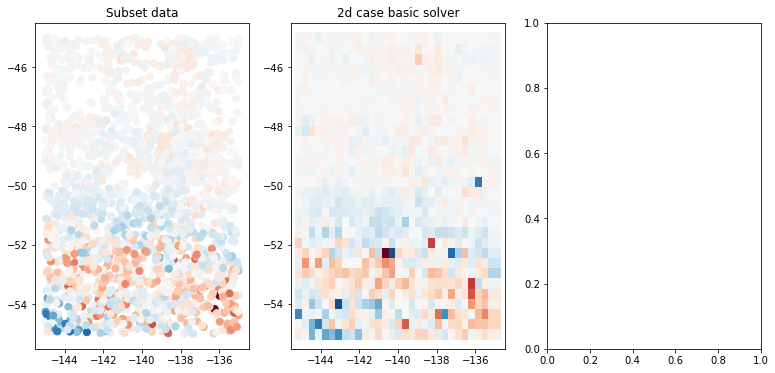

In [24]:
f, axes = plt.subplots(1, 3, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)

axes[0].set_title('Subset data')
cs=axes[0].scatter(subset.Input_coordinates[:, 0],subset.Input_coordinates[:, 1], c=subset.Anomaly_data, s=50, **style)

axes[1].set_title('2d case basic solver')


axes[1].scatter(grid_pts_2d[:, 0], grid_pts_2d[:, 1], c=predBasic, s=150, marker='s', edgecolor='none', **style)

#axes[2].set_title('2d case holdr solver')

#axes[2].scatter(grid_pts_2d[:, 0], grid_pts_2d[:, 1], c=predHODLR, s=150, marker='s', edgecolor='none', **style)
#plt.colorbar(cs)
